## Discretización más codificación 

Qué debemos hacer con las variables después de la discretización? Debemos usar los intervalos como una variable numérica? o deberíamos usar los intervalos como una variable categórica?

La respuesta es si, puedes hacer cualquiera de las dos. 

Si estás construyendo algoritmos de árboles de decisión y los resultados de la discretización son enteros (y cada entero se refiere a un intervalo), luego podemos usar estos intervalos directamente, ya que los árboles de decisión pueden encontrar relaciones no lineales entre las variables discretizadas y el target.

Si estás construyendo modelos lineales, los intervalos no necesariamente van a tener una relación lineal con el target. En este caso, puede ayudar a mejorar el desempeño del modelo para tratar los intervalos como categorías y para la codificación one hot o la codificación guida por el target como la codificación por la media, pesos de evidencia o la codificación ordinal.

Esto se puede hacer fácilmente combinando los discretizadores y codificadores de feature-engine.

## En este demo

Vas a aprender como discretizar usando igual frecuencia seguida por la codificación ordinal guiada por el target usando los datos del Titanic.

Si quieres utilizar pesos de evidencia o codificación por la media, solo necesitas reemplazar el codificador de feature-engine.


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from feature_engine.discretisation import EqualFrequencyDiscretiser
from feature_engine.encoding import OrdinalEncoder

In [2]:
# cargar variables numéricas Titanic Dataset

data = pd.read_csv('../titanic.csv',
                   usecols=['age', 'fare', 'survived'])

data.head()

,survived,age,fare
0,1,29.0000,211.3375
1,1,0.9167,151.5500
2,0,2.0000,151.5500
3,0,30.0000,151.5500
4,0,25.0000,151.5500


In [3]:
# separar en sets de entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((916, 2), (393, 2))

Las variables age y fare contienen datos faltantes. Los vamos a completar extrayendo una muestra aleatoria de la variable.

In [4]:
def impute_na(data, variable):
    
    # función para reemplazar NA con una muestra aleatoria

    df = data.copy()

    # muestra aleatoria
    df[variable+'_aleatoria'] = df[variable]

     # extraer muestra aleatoria para completar datos faltantes na
    random_sample = X_train[variable].dropna().sample(
        df[variable].isnull().sum(), random_state=0)

    # pandas necesita tener el mismo index para poder 
    # combinar los dataframes
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable+'_aleatoria'] = random_sample

    return df[variable+'_aleatoria']

In [5]:
# reemplazar los NA en sets de entrenamiento y prueba

X_train['age'] = impute_na(data, 'age')
X_test['age'] = impute_na(data, 'age')

X_train['fare'] = impute_na(data, 'fare')
X_test['fare'] = impute_na(data, 'fare')

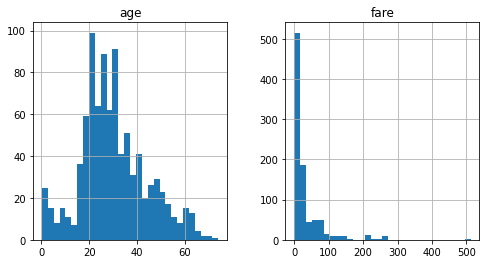

In [6]:
# exploremos la distribución de la variable age

X_train[['age', 'fare']].hist(bins=30, figsize=(8,4))
plt.show()

## Discretización Igual frecuencia con Feature-engine

In [7]:
# inicializar el discretizador de igual frecuencia
# para codificar las variables las necesitamos
# retornadas como objetos para feature-engine

disc = EqualFrequencyDiscretiser(
    q=10, variables=['age', 'fare'], return_object=True)

# encuentra los intervalos
disc.fit(X_train)

# transforma sets de entrenamieto y prueba
train_t = disc.transform(X_train)
test_t = disc.transform(X_test)

In [8]:
train_t.dtypes

age     object
fare    object
dtype: object

In [9]:
train_t.head()

,age,fare
501,0,5
588,0,6
402,5,4
1193,2,1
686,2,1


Text(0, 0.5, 'media de target - survived')

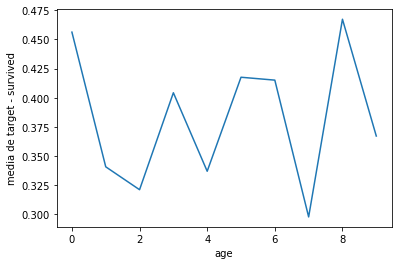

In [10]:
# exploremos si los intervalos tienen una relación lineal con el target:

pd.concat([train_t, y_train], axis=1).groupby('age')['survived'].mean().plot()
plt.ylabel('media de target - survived')

Text(0, 0.5, 'media de target - survived')

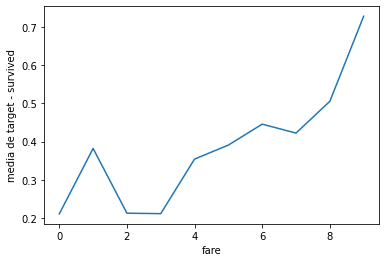

In [11]:
pd.concat([train_t, y_train], axis=1).groupby('fare')['survived'].mean().plot()
plt.ylabel('media de target - survived')

Ninguna de las variables muestra una relación monotónica con entre los intervalos de la variable discretizada y la media del target (survival). Podemos codificar los intervalos para devolver una relación monotónica.

## Codificación Ordinal con Feature-engine

In [12]:
enc = OrdinalEncoder(encoding_method = 'ordered')

enc.fit(train_t, y_train)

train_t = enc.transform(train_t)
test_t = enc.transform(test_t)

In [13]:
# en la codificación, mapeamos los intervalos a una posición
enc.encoder_dict_

{'age': {7: 0, 2: 1, 4: 2, 1: 3, 9: 4, 3: 5, 6: 6, 5: 7, 0: 8, 8: 9},
 'fare': {0: 0, 3: 1, 2: 2, 4: 3, 1: 4, 5: 5, 7: 6, 6: 7, 8: 8, 9: 9}}

Text(0, 0.5, 'media de target - survived')

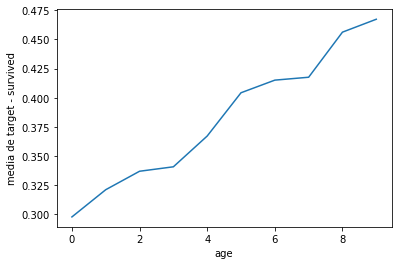

In [14]:
pd.concat([train_t, y_train], axis=1).groupby('age')['survived'].mean().plot()
plt.ylabel('media de target - survived')

Text(0, 0.5, 'media de target - survived')

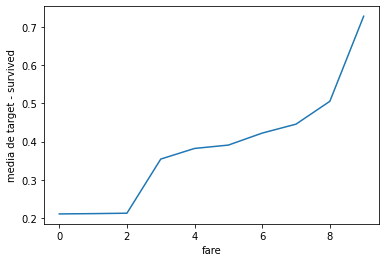

In [15]:
pd.concat([train_t, y_train], axis=1).groupby('fare')['survived'].mean().plot()
plt.ylabel('media de target - survived')

Ahora tenemos una relación monotónica entre las variable y el target.

**Eso es todo por esta demostración. Esperamos hayan disfrutado el notebook y nos vemos en el siguiente.**